
### `About the Dataset`
* `Using an article that explored how emotions are represented in English Twitter messages.`
* `This dataset contains six basic emotions: anger, disgust, fear, joy, sadness, and surprise.`
* `Given a tweet,
our task will be to train a model that can classify it into one of these emotions.`
----


In [1]:
# Create a requirements.txt file
%%writefile requirements.txt
transformers==4.44.0
datasets==2.21.0
matplotlib==3.9.2
umap-learn==0.5.6
accelerate>=0.20.1

Writing requirements.txt


In [2]:
# Install the reqs file
!pip install -qr requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 33.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 36.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/6

### `Load the Dataset`

In [3]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, accuracy_score
from transformers import Trainer, TrainingArguments
from huggingface_hub import notebook_login

In [4]:
# Load the dataset ('emotions')
emotions = load_dataset('emotion')
emotions

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
# Let's examine the dataset
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
# Check smaple of the rows in traning dataset
train_ds[0:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [7]:
# Check the datatypes and class names
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [8]:
# Let's convert it to pandas for easy working
emotions.set_format(type='pandas')
df = emotions['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
# Because the labels are represented in integers. I will craeate a function to map the integers to strings
def label_int2str(row):
  return emotions['train'].features['label'].int2str(row)

# Apply above function to the label column in the DF
df['label_name'] = df['label'].apply(label_int2str)

# Check again
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


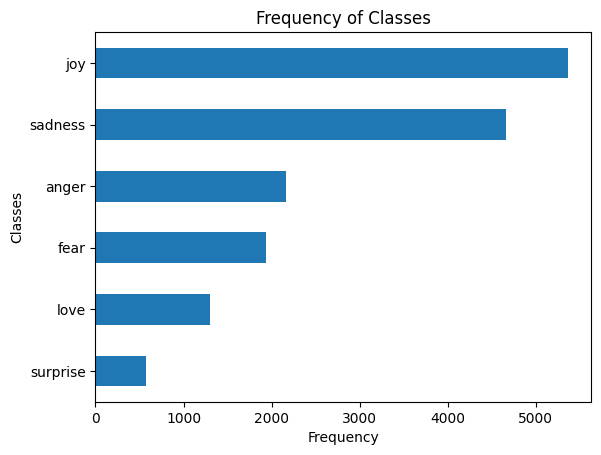

In [10]:
# Let's exmaine the class distribution
df['label_name'].value_counts(ascending=True).plot(kind='barh')
plt.title('Frequency of Classes', fontsize=12, c='k')
plt.ylabel('Classes')
plt.xlabel('Frequency')
plt.show()

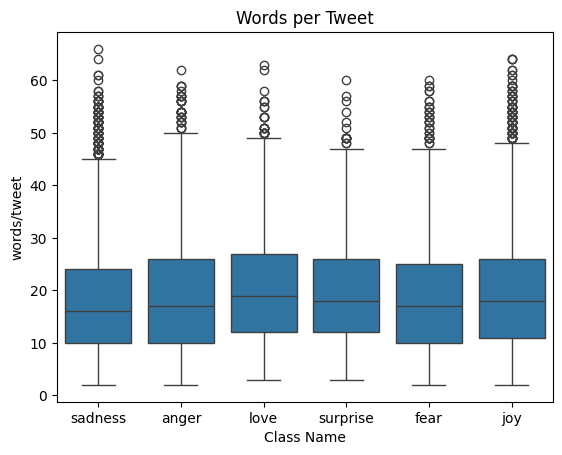

In [11]:
# Check the distribution of tweets length per each class
df['words/tweet'] = df['text'].str.split().apply(len)

# Plotting
sns.boxplot(data=df, y='words/tweet', x='label_name')
plt.title('Words per Tweet', fontsize=12, c='k')
plt.xlabel('Class Name')
plt.ylabel('words/tweet')
plt.show()

In [12]:
# Reset Format from pandas to nested dictionary
emotions.reset_format()

### `Data Preprocessing`

In [13]:
# Get the model checkPoint and load the tokenizer
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [14]:
# Let's examine the tokenizer
text = 'Tokenization is the core task of NLP'
encoded_text = tokenizer(text, return_tensors='pt')
print(encoded_text )

{'input_ids': tensor([[  101, 19204,  3989,  2003,  1996,  4563,  4708,  1997, 17953,  2361,
           102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [15]:
# To get the tokens itself
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids[0], skip_special_tokens=False)
print(tokens)

['[CLS]', 'token', '##ization', 'is', 'the', 'core', 'task', 'of', 'nl', '##p', '[SEP]']


In [16]:
# To return back to the original text
regen_text = tokenizer.convert_tokens_to_string(tokens)
print(regen_text)

[CLS] tokenization is the core task of nlp [SEP]


In [17]:
# We can check the vocab. size and the max-length of context window
print(f'The vocab size of DistillBert Model is: {tokenizer.vocab_size}')
print(f'The context window of DistillBert Model is: {tokenizer.model_max_length}')

The vocab size of DistillBert Model is: 30522
The context window of DistillBert Model is: 512


In [18]:
# Ok. Let's tokenize the whole dataset
def tokenize_fn(batch):
  ## Padding the short sentences and truncate the long sentences
  return tokenizer(batch['text'], padding=True, truncation=True, max_length=512, return_tensors='pt')

# Examine the function (for the first two examples in the dataset)
tokenize_fn(emotions['train'][0:2])

{'input_ids': tensor([[  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0],
        [  101,  1045,  2064,  2175,  2013,  3110,  2061, 20625,  2000,  2061,
          9636, 17772,  2074,  2013,  2108,  2105,  2619,  2040, 14977,  1998,
          2003,  8300,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [19]:
# Apply the above function of tokenization to the whole dataset
emotions_encoded = emotions.map(tokenize_fn, batched=True, batch_size=None)

# I dont specify the batch_size to apply to the whole dataset as a single batch. to make the input_ids and attention_mask of the same shape globally

# Check after tokenizing
emotions_encoded['train'].column_names

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']

### `Training a Text Classifier`

In [20]:
# check CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'The device is: {device}')

The device is: cuda


In [21]:
# Load the DistillBert model from its checkpoint
model = AutoModel.from_pretrained(model_ckpt).to(device)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

* `Try on Test Example`

In [22]:
# Extracting the last hidden states
text = 'This is a test'
inputs_test = tokenizer(text, return_tensors='pt')
tokens_test = tokenizer.convert_ids_to_tokens(inputs_test.input_ids[0], skip_special_tokens=False)

print('Tokens:')
print(tokens_test)
print()
print(f'Input tensor shape {inputs_test["input_ids"].size()}') # Has the shape of [batch_size x n_tokens]

Tokens:
['[CLS]', 'this', 'is', 'a', 'test', '[SEP]']

Input tensor shape torch.Size([1, 6])


In [23]:
# Pass tensors to GPU
inputs_test = {k: v.to(device) for k, v in inputs_test.items()}


# Get the model hidden states
# Using this context manager to disable calculation of the gradient
with torch.no_grad():
  outputs_test = model(**inputs_test)

print(outputs_test)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [24]:
# Let's look at the shape of the hidden state tensor
outputs_test.last_hidden_state.size()  # Has shape of [batch_size x n_tokens x hidden_dim].

# it means that a 768-dimensional vector is returned for each of 6 tokens in my test example

torch.Size([1, 6, 768])

In [25]:
# It is common practice to use just the hidden state of the [CLS] token.
outputs_test.last_hidden_state[:, 0, :].size()  # taking the first token only [CLS] for classification

torch.Size([1, 768])

* `Apply on my dataset`

In [26]:
# Let's combine that in function
def extract_hidden_states_fn(batch):

  # Place the model input to the GPU
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  # Extract the last hidden states
  with torch.no_grad():
    last_hidden_state = model(**inputs).last_hidden_state

  ## Get only the vector of the first token [CLS], and convert back to cpu and numpy
  return {'hidden_state': last_hidden_state[:, 0, :].cpu().numpy()}

# Convert the tokenized numerical data (input_ids, attention_mask, label) to tensors
# I already tokenize the dataset, so I dont even need the text column
emotions_encoded.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Apply the above function using the magic function (map) on the tokenized data
emotions_hidden = emotions_encoded.map(extract_hidden_states_fn, batched=True, batch_size=1000)
emotions_hidden

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [27]:
# Applying the above function has added a new column
emotions_hidden['train'].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [28]:
# Creating the feature matrix and the target (Train, Valid, and Test)

# Features
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
X_test = np.array(emotions_hidden['test']['hidden_state'])

# Target
y_train = np.array(emotions_hidden['train']['label'])
y_valid = np.array(emotions_hidden['validation']['label'])
y_test = np.array(emotions_hidden['test']['label'])

# Check the shapes
print('X_train.shape -->', X_train.shape)
print('y_train', y_train.shape)
print('---'*10)
print('X_valid.shape -->', X_valid.shape)
print('y_valid.shape -->', y_valid.shape)
print('---'*10)
print('X_test.shape -->', X_test.shape)
print('y_test.shape -->', y_test.shape)

X_train.shape --> (16000, 768)
y_train (16000,)
------------------------------
X_valid.shape --> (2000, 768)
y_valid.shape --> (2000,)
------------------------------
X_test.shape --> (2000, 768)
y_test.shape --> (2000,)


#### `Vizualization in 2D`

In [29]:
##Scaling the X_train features between [0, 1]
X_scaled = MinMaxScaler().fit_transform(X_train)

# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(X_scaled)
# Create a DF of 2D embeddings
df_embed = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])

# Add the label to make hue using it
df_embed['label'] = y_train

# Finally, Check
df_embed.head()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,X,Y,label
0,4.203400,6.418176,0
1,-3.136835,5.436366,0
2,5.248462,3.008415,3
3,-2.395852,3.454944,2
4,-3.388781,3.610501,3


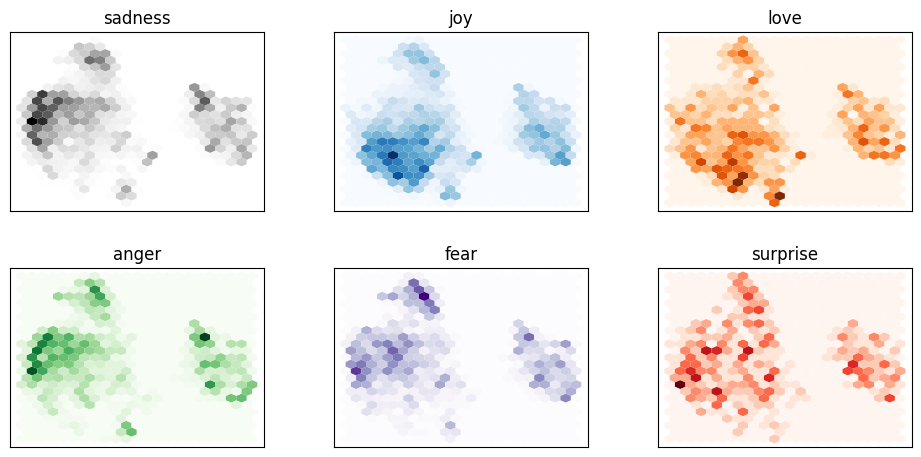

In [30]:
# Plotting (I have 6 classes)
fig, ax = plt.subplots(2, 3, figsize=(10, 5))
fig.tight_layout(pad=2)
ax = ax.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Greens', 'Purples', 'Reds']
labels = emotions['train'].features['label'].names

# Plotting using Hexagonal Binning
for i, (label, cmap) in enumerate(zip(labels, cmaps)):
  df_embed_sub = df_embed.query(f'label== {i}')
  ax[i].hexbin(df_embed_sub['X'], df_embed_sub['Y'], cmap=cmap, gridsize=22, linewidth=(0,))
  ax[i].set_title(label)
  ax[i].set_xticks([])  # make no values on x axis
  ax[i].set_yticks([])  # make no value on y axis

plt.show()

----

### `Training a BaseLine Classifier`

In [31]:
# Let's create a function for plotting the confusion matrix
labels = emotions['train'].features['label'].names

def plot_conf_matrix_fn(y_preds, y_true):
  conf_mat = confusion_matrix(y_true, y_preds, normalize='true')
  fig, ax = plt.subplots(figsize=(6, 6))

  conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=labels)
  conf_mat_disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
  plt.title('Normalized confusion Matrix', fontsize=12, c='k')
  plt.show()

Accuracy score using LogisiticRegression 0.632


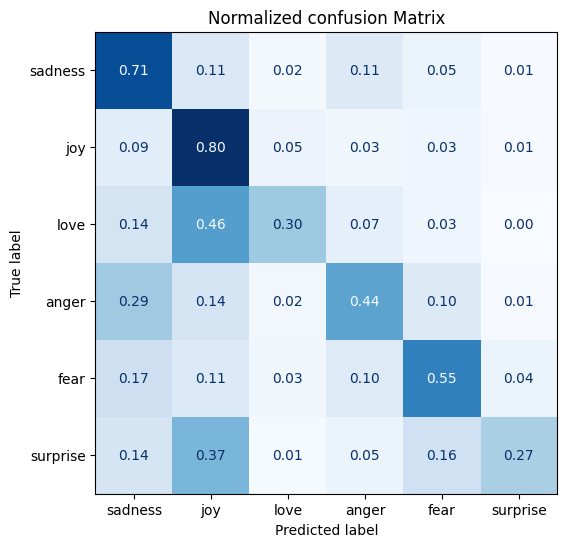

In [32]:
# Using Logistic Regression
log_clf = LogisticRegression(max_iter=3000)
log_clf.fit(X_train, y_train)

# Get the accuracy score
score_log = log_clf.score(X_valid, y_valid)
print(f'Accuracy score using LogisiticRegression {score_log:.3f}')

# Get the prediction onn valid dataset, and call the above function to draw the conf matrix
y_preds_log = log_clf.predict(X_valid)

# Call the function for plotting confusion matrix
plot_conf_matrix_fn(y_preds=y_preds_log, y_true=y_valid)

-------

### `Fine-Tuning DistillBERT`

In [64]:
# Login using Key Token from HuggingFace (to be write permission)
notebook_login()

In [65]:
# Load the model with random weights of head classifier
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6).to(device)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/12040accade4e8a0f71eabdb258fecc2e7e948be/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.44.0",
  "vocab_size": 30522
}



In [66]:
# Define the performance metrics (I will use accuracy and f1_score)
def compute_metrics_fn(pred):
  labels = pred.label_ids  # The Ground Truth
  preds = pred.predictions.argmax(-1)   # The predictions

  # Calculate the f1 & accuracy
  f1 = f1_score(labels, preds, average='weighted')  # It is multiclass
  acc = accuracy_score(labels, preds)
  return {'accuracy': acc, 'f1': f1}

In [ ]:
# Prepare the training arguments
batch_size = 32
logging_steps = len(emotions_encoded['train']) // batch_size

# a checkpoint name
my_model_chkpt = f'{model_ckpt}-finetuned-depi-before'

# Define some training arguments with updated parameters
training_args = TrainingArguments(
    output_dir=my_model_chkpt,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level='info',
    report_to=["none"]  # Explicitly disable all reporting integrations
)

PyTorch: setting up devices


In [68]:
# Initialize the Trainer API
trainer = Trainer(model=model,
                  args=training_args,
                  compute_metrics=compute_metrics_fn,
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)
# Start Training
trainer.train();

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 16,000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1,000
  Number of trainable parameters = 66,958,086


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.616600,0.219833,0.922000,0.922720
2,0.177700,0.171948,0.930000,0.929994


Saving model checkpoint to distilbert-base-uncased-finetuned-depi-before/checkpoint-500
Configuration saved in distilbert-base-uncased-finetuned-depi-before/checkpoint-500/config.json
Model weights saved in distilbert-base-uncased-finetuned-depi-before/checkpoint-500/model.safetensors
tokenizer config file saved in distilbert-base-uncased-finetuned-depi-before/checkpoint-500/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-depi-before/checkpoint-500/special_tokens_map.json
tokenizer config file saved in distilbert-base-uncased-finetuned-depi-before/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-depi-before/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Eva

In [71]:
# Examine the performance of the model on the validation dataset
preds_output_valid = trainer.predict(emotions_encoded['validation'])
preds_output_valid.predictions.shape

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Prediction *****
  Num examples = 2000
  Batch size = 32


(2000, 6)

In [70]:
# Get the metrics for the validation dataset
preds_output_valid.metrics

{'test_loss': 0.17194826900959015,
 'test_accuracy': 0.93,
 'test_f1': 0.9299937675905502,
 'test_runtime': 4.0019,
 'test_samples_per_second': 499.757,
 'test_steps_per_second': 15.742}

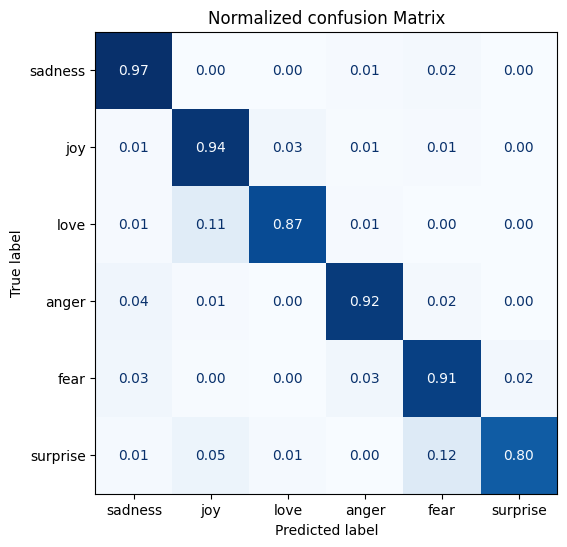

In [72]:
# Get the y_predictions
y_preds_valid = np.argmax(preds_output_valid.predictions, axis=1)

# Plotting the confusion matrix --> Calling the above function
plot_conf_matrix_fn(y_preds=y_preds_valid, y_true=y_valid)  # Great

### `Error Analysis`

In [73]:
from torch.nn.functional import cross_entropy

In [74]:
# Let's investigate the models's predictions much more
# What about sorting the validation samples by the model loss (cross entropy)


def forward_pass_label_and_loss(batch):

  # Pass the tensors to device like we did to the model
  inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}

  # inference with no gradients calculations
  with torch.no_grad():
    outputs = model(**inputs)  # Model here is my fine-tuned model with the classifier head
    pred_label = torch.argmax(outputs.logits, axis=-1)  # Getting the class index that has the top logit (max score)
    loss = cross_entropy(input=outputs.logits, target=batch['label'].to(device), reduction='none')
    return {'loss': loss.cpu().numpy(), 'predicted_label': pred_label.cpu().numpy()}


# Using the magic function (map) and apply thr above function on validation dataset
emotions_encoded['validation'] = emotions_encoded['validation'].map(forward_pass_label_and_loss, batched=True, batch_size=16)

# Check again: Created two new cols as expected (loss & predicted_label)
emotions_encoded['validation']

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'loss', 'predicted_label'],
    num_rows: 2000
})

In [75]:
# Convert to pandas
emotions_encoded.set_format('pandas')
cols = ['text', 'label', 'predicted_label', 'loss']

# Slicing the cols from the validation dataset only to work on them
df_valid_sample = emotions_encoded['validation'][:][cols]

# Convert the label & predicted_label cols to string
df_valid_sample['label'] = df_valid_sample['label'].apply(label_int2str)
df_valid_sample['predicted_label'] = df_valid_sample['predicted_label'].apply(label_int2str)

# Sort descending by loss
df_valid_sample.sort_values(by='loss', ascending=False, inplace=True)

# Check head the DF (the loss is high at the start of DF)
df_valid_sample.head(10)

,text,label,predicted_label,loss
1950,i as representative of everything thats wrong ...,surprise,sadness,7.059186
1500,i guess we would naturally feel a sense of lon...,anger,sadness,6.372675
1801,i feel that he was being overshadowed by the s...,love,sadness,6.342790
1963,i called myself pro life and voted for perry w...,joy,sadness,6.292879
1870,i guess i feel betrayed because i admired him ...,joy,sadness,6.282835
1111,im lazy my characters fall into categories of ...,joy,fear,5.788395
882,i feel badly about reneging on my commitment t...,love,sadness,5.777511
1274,i am going to several holiday parties and i ca...,joy,sadness,4.980827
1683,i had applied for a job and they had assured m...,anger,joy,4.679206
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.302326


> `There are some incorrect labelling of some instances in the dataset, That may causes errors in fine-tuned model`

In [ ]:
# Check the tail DF (the loss is low at the end of DF)
df_valid_sample.tail(10)

,text,label,predicted_label,loss
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.000871
267,i feel like im alone in missing him and becaus...,sadness,sadness,0.000871
866,i feel quite jaded and unenthusiastic about li...,sadness,sadness,0.000869
1621,i feel so disturbed and unsettled that i m not...,sadness,sadness,0.000868
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.000864
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.000856
69,i have no extra money im worried all of the ti...,sadness,sadness,0.000842
1310,i feel like an ungrateful asshole,sadness,sadness,0.000839
1368,i started this blog with pure intentions i mus...,sadness,sadness,0.000838
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.000829


In [76]:
# Finally, Saving and sharing model
trainer.push_to_hub(commit_message='Training Complete')

Saving model checkpoint to distilbert-base-uncased-finetuned-depi-before
Configuration saved in distilbert-base-uncased-finetuned-depi-before/config.json
Model weights saved in distilbert-base-uncased-finetuned-depi-before/model.safetensors
tokenizer config file saved in distilbert-base-uncased-finetuned-depi-before/tokenizer_config.json
Special tokens file saved in distilbert-base-uncased-finetuned-depi-before/special_tokens_map.json
Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}, 'metrics': [{'name': 'Accuracy', 'type': 'accuracy', 'value': 0.93}, {'name': 'F1', 'type': 'f1', 'value': 0.9299937675905502}]}


CommitInfo(commit_url='https://huggingface.co/agoor97/distilbert-base-uncased-finetuned-depi-before/commit/70c4927941b50d1d86f2e12022018e4e36f3a096', commit_message='Training Complete', commit_description='', oid='70c4927941b50d1d86f2e12022018e4e36f3a096', pr_url=None, repo_url=RepoUrl('https://huggingface.co/agoor97/distilbert-base-uncased-finetuned-depi-before', endpoint='https://huggingface.co', repo_type='model', repo_id='agoor97/distilbert-base-uncased-finetuned-depi-before'), pr_revision=None, pr_num=None)

---

### `Use the model via pipeline`

In [77]:
from transformers import pipeline
import logging

In [79]:
# Set logging level to ERROR to suppress informational messages
logging.getLogger('transformers').setLevel(logging.ERROR)


# Use a pipeline as a high-level helper using my checkpoint
classifier = pipeline('text-classification', model='agoor97/distilbert-base-uncased-finetuned-depi-before')

config.json:   0%|          | 0.00/883 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

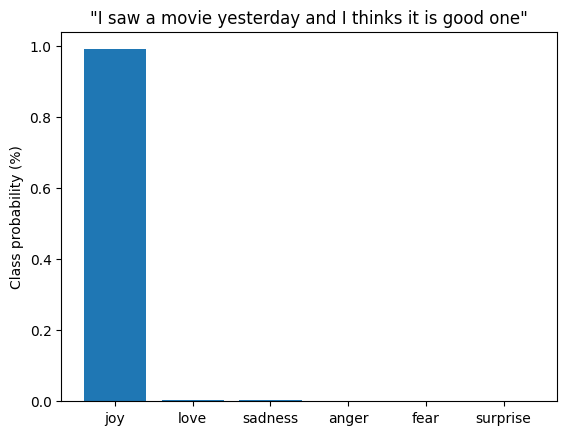

In [80]:
# Predict on custom tweet
custom_tweet = 'I saw a movie yesterday and I thinks it is good one'
preds_custom = classifier(custom_tweet, top_k=None)

# Define the label mapping
label_mapping = {
    'LABEL_0': 'sadness',
    'LABEL_1': 'joy',
    'LABEL_2': 'love',
    'LABEL_3': 'anger',
    'LABEL_4': 'fear',
    'LABEL_5': 'surprise'
}

# Extract class labels and scores with human-readable labels
labels = [label_mapping[pred['label']] for pred in preds_custom]
scores = [pred['score'] for pred in preds_custom]


# Plotting the class probabilities
plt.bar(labels, scores, color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel('Class probability (%)')
plt.show()

### `Evaluate on Test Dataset`

In [81]:
# Evaluate on test dataset (The dataset which will passed to classifier is just a natural language)
y_pred_test = classifier(emotions['test']['text'])

In [82]:
# Slicing only the number of label from the output of the classifier
preds_test = []
for each_pred in y_pred_test:
  preds_test.append(int(each_pred['label'].split('_')[-1]))

In [83]:
# Here is a DF for the test dataset contains the text, ground truth (label), and the predicted label
df_preds_test = pd.DataFrame({'text': emotions['test']['text'], 'label': emotions['test']['label'], 'predicted': preds_test})
df_preds_test

,text,label,predicted
0,im feeling rather rotten so im not very ambiti...,0,0
1,im updating my blog because i feel shitty,0,0
2,i never make her separate from me because i do...,0,0
3,i left with my bouquet of red and yellow tulip...,1,1
4,i was feeling a little vain when i did this one,0,0
...,...,...,...
1995,i just keep feeling like someone is being unki...,3,0
1996,im feeling a little cranky negative after this...,3,3
1997,i feel that i am useful to my people and that ...,1,1
1998,im feeling more comfortable with derby i feel ...,1,1


In [84]:
# Get the scores on test dataset
acc_test = accuracy_score(df_preds_test['label'], df_preds_test['predicted'])
f1_test = f1_score(df_preds_test['label'], df_preds_test['predicted'], average='weighted')

print(f'The accuracy score on Test Dataset is: {acc_test:.3f}')
print(f'The f1_score on Test Dataset is: {f1_test:.3f}')

The accuracy score on Test Dataset is: 0.912
The f1_score on Test Dataset is: 0.912


----